In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
json_file_path = '/content/drive/MyDrive/train.json'
import json
with open(json_file_path, 'r') as file:
    train_data = json.load(file)


In [6]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn as nn
import torch.optim as optim


In [7]:
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
clinical_bert_model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels = 2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
print(clinical_bert_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
model = clinical_bert_model

In [11]:
label_mapping = {
    'Entailment': 1,
    'Contradiction': 0
}

In [12]:
import json
import os
import re
import random
from torch.utils.data import DataLoader


ctr_json_folder = '/content/drive/MyDrive/CT json' 




def preprocess_data(train_data):
    preprocessed_data = []
    augmented_data = []  
    for data_id, data in train_data.items():
        ctr_1 = data['Primary_id'] + '.json'
        ctr_1f = os.path.join(ctr_json_folder, ctr_1)
        secondaryid_exists = False
        if 'Secondary_id' in data:
            ctr_2 = data['Secondary_id'] + '.json'
            ctr_2f = os.path.join(ctr_json_folder, ctr_2)
            secondaryid_exists = True

        with open(ctr_1f, 'r') as file:
            ctr_a = json.load(file)
            if secondaryid_exists:
                with open(ctr_2f, 'r') as file:
                    ctr_b = json.load(file)
                ctr = "Compare CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']])  + "[SEP]"+ "and CTR 2" + " [SEP] ".join(
                    ctr_b[data["Section_id"]]) + "to determine if the given statement" + " [SEP] " + data["Statement"] +"[SEP]"+"is true"
            else:
                ctr = "Analyze CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']]) + "[SEP]"+" To determine if the given Statement" + " [SEP] " + data["Statement"]+"[SEP]"+"is true"
        ctr = ctr.lower()
        url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

        ctr = re.sub(url_ptrn, '', ctr)
        ctr = re.sub(r'[^\w\s]', '', ctr)

        inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
        labels = torch.tensor([label_mapping[data['Label']]])

        preprocessed_data.append((inputs, labels))

    return preprocessed_data


In [13]:

preprocessed_data = preprocess_data(train_data)



In [14]:
print(len(preprocessed_data))

1700


In [15]:
import json
with open('/content/drive/MyDrive/dev.json', 'r') as file:
    dev_data = json.load(file)

dev_preprocessed_data = preprocess_data(dev_data)

In [16]:
import numpy as np


data = preprocessed_data + dev_preprocessed_data
data = list(data)
val_size = int(len(data) * 0.15)

np.random.shuffle(data)

val_data = data[:val_size]
train_data = data[val_size:]


In [17]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(preprocessed_data, batch_size=batch_size)
val_loader = DataLoader(dev_preprocessed_data, batch_size=batch_size)

In [18]:
for param in list(model.parameters())[:-3]:
    param.requires_grad = False

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [20]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
from sklearn.metrics import accuracy_score


device = torch.device('cuda')

model.to(device)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
NUM_EPOCHS=50
best_val_acc = float('-inf')


for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    train_predicted = []
    train_labels = []
    for batch in train_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']

        labels = batch[1].to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.logits, 1)
        train_predicted.extend(predicted.tolist())
        train_labels.extend(labels.tolist())
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    train_loss = total_train_loss / len(train_loader)
    train_acc_score = accuracy_score(train_labels, train_predicted)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc_score)


    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_predicted = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']

            labels = batch[1].to(device)
            input_ids = input_ids.squeeze(1).to(device)
            attention_mask = attention_mask.squeeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            val_predicted.extend(predicted.tolist())
            val_labels.extend(labels.tolist())
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = total_val_loss / len(val_loader)
    val_acc_score = accuracy_score(val_labels, val_predicted)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc_score)

    if val_acc_score > best_val_acc:
        best_val_acc = val_acc_score
        torch.save(model.state_dict(), '/content/drive/MyDrive/NLP_milestone3_clinibert_train_dev.pth')

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc_score:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc_score:.4f}')

Epoch 1/50, Train Loss: 0.7138, Train Accuracy: 0.4912, Val Loss: 0.6999, Val Accuracy: 0.5050
Epoch 2/50, Train Loss: 0.7014, Train Accuracy: 0.4976, Val Loss: 0.6963, Val Accuracy: 0.5050
Epoch 3/50, Train Loss: 0.7022, Train Accuracy: 0.4806, Val Loss: 0.6963, Val Accuracy: 0.4950
Epoch 4/50, Train Loss: 0.7001, Train Accuracy: 0.4976, Val Loss: 0.6962, Val Accuracy: 0.5000
Epoch 5/50, Train Loss: 0.7029, Train Accuracy: 0.4818, Val Loss: 0.6958, Val Accuracy: 0.5000
Epoch 6/50, Train Loss: 0.6976, Train Accuracy: 0.4982, Val Loss: 0.6961, Val Accuracy: 0.5000
Epoch 7/50, Train Loss: 0.6954, Train Accuracy: 0.5153, Val Loss: 0.6956, Val Accuracy: 0.5100
Epoch 8/50, Train Loss: 0.6963, Train Accuracy: 0.5112, Val Loss: 0.6952, Val Accuracy: 0.5000
Epoch 9/50, Train Loss: 0.6953, Train Accuracy: 0.5035, Val Loss: 0.6956, Val Accuracy: 0.5050
Epoch 10/50, Train Loss: 0.6962, Train Accuracy: 0.5006, Val Loss: 0.6954, Val Accuracy: 0.5000
Epoch 11/50, Train Loss: 0.6945, Train Accuracy: 

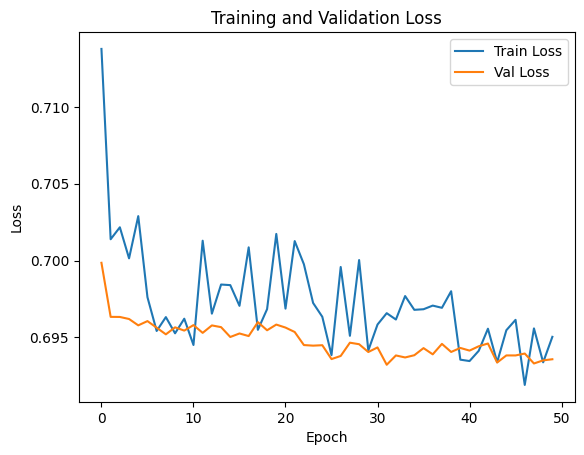

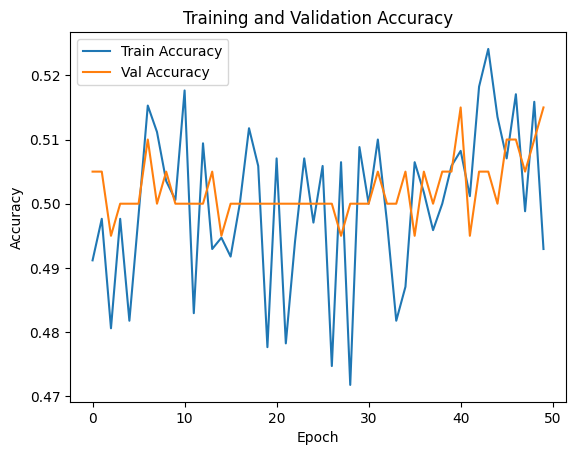

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot( val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot( train_accuracies, label='Train Accuracy')
plt.plot( val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']
        labels = batch[1].to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


Accuracy: 0.5150
Precision: 0.5302, Recall: 0.5150, F1 Score: 0.4451


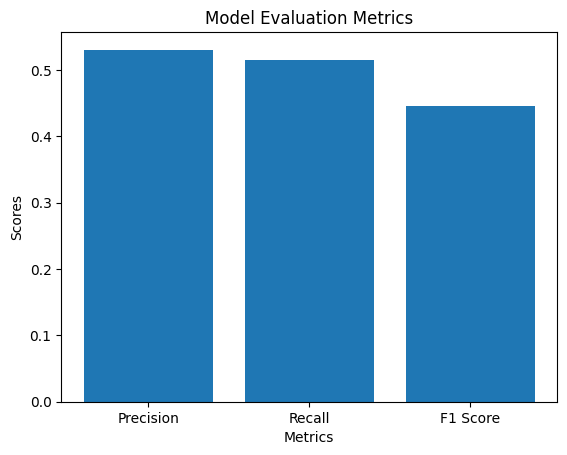

In [23]:

plt.bar(labels, scores)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.show()




In [24]:
# model.load_state_dict(torch.load('milestone2_NLP_model_state.pth'))

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [25]:

json_file_path = '/content/drive/MyDrive/gold_practice_test.json'
import json
# Load the JSON file
with open(json_file_path, 'r') as file:
    gold_practice_test = json.load(file)

In [26]:
gold_test = preprocess_data(gold_practice_test)

In [27]:
from torch.utils.data import DataLoader

batch_size = 64
gold_test_loader = DataLoader(gold_test, batch_size=batch_size)

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in gold_test_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']
        labels = batch[1].to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())


In [29]:
import numpy as np

true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


Accuracy: 0.3917
Precision: 0.5707, Recall: 0.3917, F1 Score: 0.3236


In [30]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
faithfulness = sum(abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [31]:
print(faithfulness)

[0.60830999]


In [32]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
consistency = sum(1-abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [33]:
print(consistency)

[0.39169001]


In [34]:
json_file_path = '/content/drive/MyDrive/test.json'
import json
with open(json_file_path, 'r') as file:
    test_data = json.load(file)



In [35]:
import json

test_preprocessed_data = []
data_ids = [] 

for data_id, data in test_data.items():
    ctr_1 = data['Primary_id'] + '.json'
    ctr_1f = os.path.join('/content/drive/MyDrive/CT json', ctr_1)
    secondaryid_exists = False
    if 'Secondary_id' in data:
        ctr_2 = data['Secondary_id'] + '.json'
        ctr_2f = os.path.join('/content/drive/MyDrive/CT json', ctr_2)
        secondaryid_exists = True

    with open(ctr_1f, 'r') as file:
        ctr_a = json.load(file)
        if secondaryid_exists:
            with open(ctr_2f, 'r') as file:
                ctr_b = json.load(file)
            ctr = " ".join(ctr_a[data['Section_id']]) + " [SEP] " + \
                  " ".join(ctr_b[data["Section_id"]]) + " [SEP] " + data["Statement"]
        else:
            ctr = " ".join(ctr_a[data['Section_id']]) + " [SEP] " + data["Statement"]

    ctr = ctr.lower()
    url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    ctr = re.sub(url_ptrn, '', ctr)
    ctr = re.sub(r'[^\w\s]', '', ctr)

    inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)

    test_preprocessed_data.append(inputs)
    data_ids.append(data_id) 


In [36]:
from torch.utils.data import DataLoader

batch_size = 32
test_loader = DataLoader(test_preprocessed_data, batch_size=batch_size)

In [37]:

model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader: 
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())


In [38]:

predictions_dict = {}
for data_id, prediction in zip(data_ids, predictions):
    prediction_label = "Contradiction" if prediction == 0 else "Entailment"
    predictions_dict[data_id] = {"Prediction": prediction_label}

output_file_path = '/content/drive/MyDrive/predictions_train_dev.json'
with open(output_file_path, "w") as f:
    json.dump(predictions_dict, f, indent=4)

print("Predictions saved to:", output_file_path)


Predictions saved to: /content/drive/MyDrive/predictions_train_dev.json
